In [1]:
import netCDF4 as nc
import numpy as np
from mpl_toolkits import mplot3d
import tensorflow as tf
from tensorflow.keras import backend as K
%load_ext tensorboard
import logging
#tf.logging.set_verbosity(tf.logging.DEBUG)
#%load_ext tensorboard
import glob,os,re,sys
import time
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
#from statsmodels.graphics.tsaplots import plot_acf
#from scipy import signal, fft, stats
import h5py
#import imageio
from sklearn.model_selection import ShuffleSplit, train_test_split
import pickle
import datetime
from math import *
import random
import seaborn as sns
from tensorflow.keras.utils import Sequence
import sklearn.cluster
from sklearn import metrics
from scipy.spatial.distance import cdist
import scipy.stats as stats
import scipy.fft as fft

In [2]:
## LOAD THE DATASETS
start = time.time()

# SCALE idealized experiments : 10 min pairs
Xi_train_LR = pickle.load(open('/data_aip03/gaudrey/SCALE_10min_pairs/X_train_LR_cluster_8.pckl', 'rb')).astype('float32')
Yi_train    = pickle.load(open('/data_aip03/gaudrey/SCALE_10min_pairs/Y_train_cluster_8.pckl', 'rb')).astype('float32')
Xi_test_LR  = pickle.load(open('/data_aip03/gaudrey/SCALE_10min_pairs/X_test_LR_cluster_8.pckl', 'rb')).astype('float32')
Yi_test     = pickle.load(open('/data_aip03/gaudrey/SCALE_10min_pairs/Y_test_cluster_8.pckl', 'rb')).astype('float32')

# SCALE real-topography experiments : 10 min pairs
"""

Xi_train_LR = pickle.load(open('/data_aip03/gaudrey/SCALE_10min_pairs/NewData_trainLR_cluster=6.pckl', 'rb')).astype('float32')
Yi_train    = pickle.load(open('/data_aip03/gaudrey/SCALE_10min_pairs/NewData_trainHR_cluster=6.pckl', 'rb')).astype('float32')
Xi_test_LR  = pickle.load(open('/data_aip03/gaudrey/SCALE_10min_pairs/NewData_testLR_cluster=6.pckl', 'rb')).astype('float32')
Yi_test     = pickle.load(open('/data_aip03/gaudrey/SCALE_10min_pairs/NewData_testHR_cluster=6.pckl', 'rb')).astype('float32')
"""

print("Train : inputs shape :",  Xi_train_LR.shape, "   targets shape : ", Yi_train.shape)
print("Test  : inputs shape :",  Xi_test_LR.shape, "    targets shape : ", Yi_test.shape)
_, ydim_LR, xdim_LR, = Xi_train_LR.shape
_, ydim_HR, xdim_HR, = Yi_train.shape
print("Mean HR : %.3f   Standard deviation HR : %.3f"%(np.mean(Yi_train), np.std(Yi_train)))
print("Computation time : %ds"%(time.time() - start))

Train : inputs shape : (800, 80, 80)    targets shape :  (800, 160, 160)
Test  : inputs shape : (200, 80, 80)     targets shape :  (200, 160, 160)
Mean HR : 0.750   Standard deviation HR : 1.866
Computation time : 0s


In [3]:
## SEPARATE STRUCUTURE AND RESIDUALS FOR INPUTS (LR) AND TARGETS (HR)
# residuals_i = image_i - mean_i=1-->n(n_cluster_images)
Xi_train_LR_res = Xi_train_LR - np.mean(Xi_train_LR, axis = 0)
Xi_test_LR_res  = Xi_test_LR  - np.mean(Xi_test_LR, axis = 0)

Yi_train_res = Yi_train - np.mean(Yi_train, axis = 0)
Yi_test_res  = Yi_test  - np.mean(Yi_test, axis = 0)

# structure_i = bilinear_interpolation_resize=80x80-->160x160(image_i)
Yi_train_struc = np.array(tf.image.resize(tf.image.resize(Yi_train.reshape(800,160,160,1), (80,80)), (160,160))).reshape(800,160,160)
Yi_test_struc  = np.array(tf.image.resize(tf.image.resize(Yi_test.reshape(200,160,160,1), (80,80)), (160,160))).reshape(200,160,160)

print("train :", Xi_train_LR_res.shape, Yi_train_res.shape, Yi_train_struc.shape, "\nTest :", Xi_test_LR_res.shape, Yi_test_res.shape, Yi_test_struc.shape)

train : (800, 80, 80) (800, 160, 160) (800, 160, 160) 
Test : (200, 80, 80) (200, 160, 160) (200, 160, 160)


2022-05-12 13:46:56.789412: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-12 13:46:57.283217: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38414 MB memory:  -> device: 0, name: A100-PCIE-40GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


In [4]:
def struct_res_vizu(LR, LRmean, LRres, HR, HRstruc, HRres):
    nb_levels = 20
    cmap = 'viridis'
    cmin_LR = np.min([np.min(LR), np.min(LRmean)])
    cmax_LR = np.min([np.max(LR), np.max(LRmean)])
    
    fig1 = plt.figure(figsize = (25,5))
    
    ax11 = fig1.add_subplot(1,3,1)
    cax11 = ax11.contourf(LR, vmin = cmin_LR, vmax = cmax_LR, cmap = cmap, levels = nb_levels)
    ax11.set_title('LR input.', fontweight = 'bold', size = 17)
    plt.colorbar(cax11)
    
    ax12 = fig1.add_subplot(1,3,2)
    cax12 = ax12.contourf(LRmean, vmin = cmin_LR, vmax = cmax_LR, cmap = cmap, levels = nb_levels)
    ax12.set_title('LR inputs mean over cluster.', fontweight = 'bold', size = 17)
    plt.colorbar(cax12)
    
    ax13 = fig1.add_subplot(1,3,3)
    cax13 = ax13.contourf(LRres, cmap = cmap, vmin = -18, vmax = 30, levels = nb_levels)
    ax13.set_title('LR input residuals.', fontweight = 'bold', size = 17)
    plt.colorbar(cax13)
    
    cmin_HR = np.min([np.min(HR), np.min(HRstruc)])
    cmax_HR = np.max([np.max(HR), np.max(HRstruc)])

    fig2 = plt.figure(figsize = (25,5))
    
    ax21 = fig2.add_subplot(1,3,1)
    cax21 = ax21.contourf(HR , vmin = cmin_HR, vmax = cmax_HR, cmap = cmap, levels = nb_levels)
    ax21.set_title('HR target.', fontweight = 'bold', size = 17)
    plt.colorbar(cax21)
    
    ax22 = fig2.add_subplot(1,3,2)
    cax22 = ax22.contourf(HRstruc, vmin = cmin_HR, vmax = cmax_HR, cmap = cmap, levels = nb_levels)
    ax22.set_title('HR target structure.', fontweight = 'bold', size = 17)
    plt.colorbar(cax22)
    
    ax23 = fig2.add_subplot(1,3,3)
    cax23 = ax23.contourf(HRres, cmap = cmap, vmin = -18, vmax = 30, levels = nb_levels)
    ax23.set_title('HR target residuals.', fontweight = 'bold', size = 17)
    plt.colorbar(cax23)

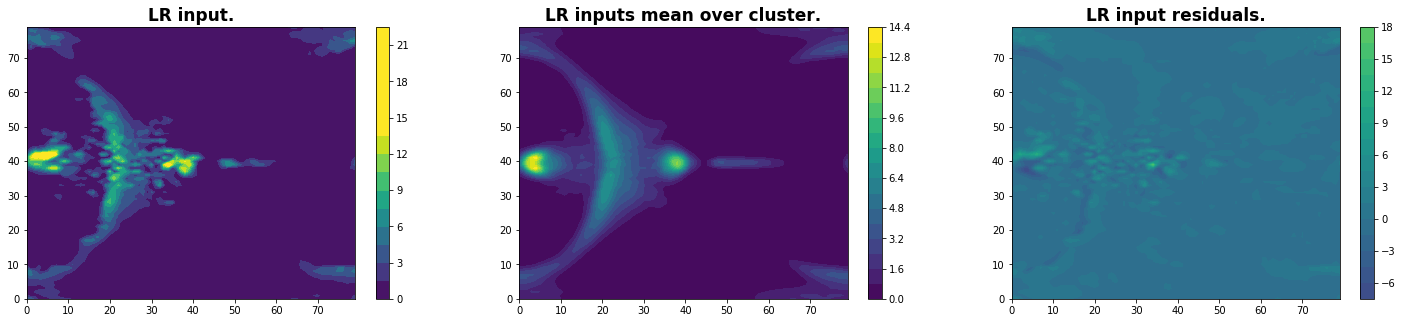

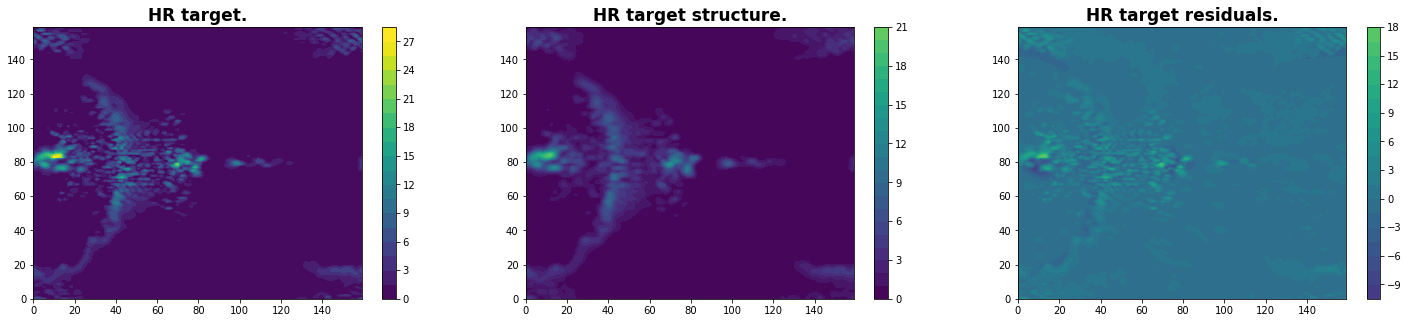

In [5]:
snapshot = 0
struct_res_vizu(Xi_test_LR[snapshot], np.mean(Xi_test_LR, axis = 0), Xi_test_LR_res[snapshot], Yi_test[snapshot], Yi_test_struc[snapshot], Yi_test_res[snapshot])

In [6]:
## MULTI-SCALE SR MODEL IMPLEMENTATION AND SIDE TRAINING PARARMETERS
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    strategy = tf.distribute.MirroredStrategy()#devices=["/gpu:0","/gpu:1"],cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
    num_GPUs = strategy.num_replicas_in_sync
    print('Number of devices: {}'.format(num_GPUs))
    print('→',[tf.config.experimental.get_memory_info('GPU:'+str(i)) for i in range(num_GPUs)], 'bytes')
    physical_devices = tf.config.list_physical_devices('GPU') 
    
with strategy.scope():
    params = {}
    params['epochs'] = 500
    params['epochs_last'] = 1000
    params['nb_subsets'] = 20
    params['subsets_size'] = 0
    params['nb_samples'] = 1000
    params['batchsize'] = 32
    params['f21_nb_filters'] = 128
    params['f22_nb_filters'] = 64
    params['f21_filters_size'] = 7 
    params['f22_filters_size'] = 7 
    params['drop'] = 0.05

    def f1_block(input_1, input_2, f1_block_nb, block_name='f1'):
        with K.name_scope(block_name):
            if f1_block_nb == 1 or f1_block_nb == 2:
                nb_filters = params['f21_nb_filters']
                filter_size = params['f21_filters_size']
            elif f1_block_nb == 3 or f1_block_nb == 4:
                nb_filters = params['f22_nb_filters']  
                filter_size = params['f22_filters_size']
            if f1_block_nb == 4:
                x_1  = tf.keras.layers.Conv2D(filters = nb_filters, kernel_size = filter_size, padding = 'same',
                                              input_shape = (ydim_LR, xdim_LR, params['f21_nb_filters']))(input_2)
                x_21 = tf.keras.layers.Conv2D(filters = nb_filters, kernel_size = filter_size, padding = 'same',
                                              input_shape = (ydim_LR, xdim_LR, params['f21_nb_filters']))(input_2)
                x_22 = tf.keras.layers.Conv2D(filters = nb_filters, kernel_size = filter_size, padding = 'same', 
                                              input_shape = (ydim_LR, xdim_LR, nb_filters))(x_21)
            else :
                x_1  = tf.keras.layers.Conv2D(filters = nb_filters, kernel_size = filter_size, padding = 'same',
                                              input_shape = (ydim_LR, xdim_LR, params['f21_nb_filters']))(input_2)
                x_21 = tf.keras.layers.Conv2D(filters = nb_filters, kernel_size = filter_size, padding = 'same',
                                              input_shape = (ydim_LR, xdim_LR, params['f21_nb_filters']))(input_2)
                x_22 = tf.keras.layers.Conv2D(filters = nb_filters, kernel_size = filter_size, padding = 'same', 
                                              input_shape = (ydim_LR, xdim_LR, nb_filters))(x_21)
            if f1_block_nb != 1:
                if f1_block_nb == 4 :
                    x_3 = tf.keras.layers.Conv2D(filters = nb_filters, kernel_size = filter_size, padding = 'same', 
                                              input_shape = (ydim_LR, xdim_LR, params['f21_nb_filters']))(input_1)
                else :
                    x_3 = tf.keras.layers.Conv2D(filters = nb_filters, kernel_size = filter_size, padding = 'same',
                                                 input_shape = (ydim_LR, xdim_LR, params['f21_nb_filters']))(input_1)
                return tf.keras.layers.Add()([x_1, x_22, x_3])
            return tf.keras.layers.Add()([x_1, x_22])

    def fractal_block(LR_residuals, block_name='fractal_block'):
        with K.name_scope(block_name):
            x_in = tf.keras.layers.Conv2D(filters = params['f21_nb_filters'], kernel_size = params['f21_filters_size'], 
                                          padding = 'same', activation = 'relu', input_shape = (ydim_LR, xdim_LR, 1))(LR_residuals)
            x_in = tf.keras.layers.Dropout(params['drop'])(x_in)
            x  = tf.keras.layers.Conv2D(filters = params['f22_nb_filters'], kernel_size = params['f22_filters_size'], 
                                          padding = 'same', activation = 'relu', input_shape = (ydim_LR, xdim_LR, params['f21_nb_filters']))(x_in)
            x = f1_block(x_in, x, 1)
            x = tf.keras.layers.Dropout(params['drop'])(x)
            x = f1_block(x_in, x, 2)
            x = tf.keras.layers.Dropout(params['drop'])(x)
            x = f1_block(x_in, x, 3)
            x = tf.keras.layers.Dropout(params['drop'])(x)
            x = f1_block(x_in, x, 4)

            x = tf.keras.layers.Conv2D(filters = 4, kernel_size = (1,1), padding = 'same', 
                                       input_shape = (ydim_LR, xdim_LR, params['f22_nb_filters']))(x)
            x = tf.nn.depth_to_space(x, block_size = 2, data_format = 'NHWC', name = 'residuals_output')
        return x

    def structural_block(LR_input):
        x = tf.keras.layers.Conv2D(filters = 128, kernel_size = 7, padding = 'same', activation = 'relu', input_shape = (ydim_LR, xdim_LR, 1))(LR_input)
        x = tf.keras.layers.Conv2D(filters = 64, kernel_size = 7, padding = 'same', activation = 'relu', input_shape = (ydim_LR, xdim_LR, 128))(x)  
        x = tf.keras.layers.Conv2D(filters = 4, kernel_size = 5, padding = 'same', activation = 'relu', input_shape = (ydim_LR, xdim_LR, 64))(x)  
        x = tf.nn.depth_to_space(x, block_size = 2, data_format = 'NHWC', name = 'structural_output')
        return x
    
    def reconstruction_block(pred_struc, pred_res):
        x1 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu', input_shape = (ydim_LR, xdim_LR, 1))(pred_struc)  
        x2 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu', input_shape = (ydim_LR, xdim_LR, 1))(pred_res)  

        x3 = tf.keras.layers.Add()([x1, x2])
        x3 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 7, padding = 'same', activation = 'relu', input_shape = (ydim_HR, xdim_HR, 64))(x3)
        x3 = tf.keras.layers.Conv2D(filters = 1, kernel_size = 5, padding = 'same', activation = 'relu', input_shape = (ydim_HR, xdim_HR, 1))(x3)
        return x3
        
    
    LR_input    = tf.keras.Input(shape = (ydim_LR, xdim_LR,1))
    struc_out   = structural_block(LR_input)
    model_struc = tf.keras.Model(LR_input, struc_out, name = 'structural_model')
    print(model_struc.summary())
    
    LR_res    = tf.keras.Input(shape = (ydim_LR, xdim_LR,1))
    res_out   = fractal_block(LR_res)
    model_res = tf.keras.Model(LR_res, res_out, name = 'residual_model')
    print(model_res.summary())
    
    pred_struc = tf.keras.Input(shape = (ydim_HR, xdim_HR, 1))
    pred_res   = tf.keras.Input(shape = (ydim_HR, xdim_HR, 1))
    rec_out    = reconstruction_block(pred_struc, pred_res)
    model_rec  = tf.keras.Model([pred_struc, pred_res], rec_out, name = 'residual_model')
    print(model_rec.summary())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1
→ [{'current': 1280, 'peak': 102401280}] bytes
Model: "structural_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 80, 80, 128)       6400      
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 64)        401472    
                                                                 
 conv2d_2 (Conv2D)           (None, 80, 80, 4)         6404      
                                                                 
 tf.nn.depth_to_space (TFOpL  (None, 160, 160, 1)      0         
 ambda)                                                          
            

Model: "residual_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 160, 160, 64  1664        ['input_3[0][0]']                
                                )                                                    

In [7]:
## MONITORING AND EVALUATION METRICS
threshold = 4
std = tf.math.reduce_std(Yi_train)
def TP(y_true, y_pred):
    true=tf.where(y_true > threshold, tf.ones_like(y_true), tf.zeros_like(y_true))
    pred=tf.where(y_pred > threshold, tf.ones_like(y_pred), tf.zeros_like(y_pred))
    pred, true = tf.cast(pred, dtype = 'float32'), tf.cast(true, dtype = 'float32')
    TP = np.sum(pred * tf.reshape(true, pred.shape))
    return TP
def TN(y_true, y_pred):
    true=tf.where(y_true < threshold, tf.ones_like(y_true), tf.zeros_like(y_true))
    pred=tf.where(y_pred < threshold, tf.ones_like(y_pred), tf.zeros_like(y_pred))
    TN = tf.reduce_sum(tf.reduce_sum(pred * true, axis = 1), axis = 1)
    return TN
def FP(y_true, y_pred):
    true=tf.where(y_true < threshold, tf.ones_like(y_true), tf.zeros_like(y_true))
    pred=tf.where(y_pred > threshold, tf.ones_like(y_pred), tf.zeros_like(y_pred))
    pred, true = tf.cast(pred, dtype = 'float32'), tf.cast(true, dtype = 'float32')
    FP = np.sum(pred * tf.reshape(true, pred.shape))
    return FP
def FN(y_true, y_pred):
    true=tf.where(y_true > threshold, tf.ones_like(y_true), tf.zeros_like(y_true))
    pred=tf.where(y_pred < threshold, tf.ones_like(y_pred), tf.zeros_like(y_pred))
    pred, true = tf.cast(pred, dtype = 'float32'), tf.cast(true, dtype = 'float32')
    FN = np.sum(pred * tf.reshape(true, pred.shape))
    return FN
def threat_score(y_true, y_pred):
    tp=TP(y_true, y_pred)
    fp=FP(y_true, y_pred)
    fn=FN(y_true, y_pred)
    ts=tp/(tp+fp+fn)
    return tp, fp, fn, ts
def threat_score_residuals(y_true, y_pred):
    y_true_pos, y_pred_pos = tf.cast(tf.reshape(y_true, y_pred.shape) > 0, y_true.dtype)*tf.reshape(y_true, y_pred.shape), tf.cast(y_pred > 0, y_true.dtype)*y_pred
    TS_pos = threat_score(y_true_pos, y_pred_pos)
    y_true_neg, y_pred_neg = tf.cast(tf.reshape(y_true, y_pred.shape) < 0, y_true.dtype)*tf.reshape(y_true, y_pred.shape), tf.cast(y_pred < 0, y_true.dtype)*y_pred
    TS_neg = threat_score(abs(y_true_neg), abs(y_pred_neg))
    return (TS_pos + TS_neg)/2
def bias(y_true, y_pred):
    y_true = tf.cast(y_true, y_pred.dtype)
    y_true = tf.reshape(y_true, y_pred.shape)
    return np.sum(y_pred - y_true)
def NMSE(y_true, y_pred):
    return tf.keras.metrics.mean_squared_error(y_pred, y_true)/std

In [8]:
## TRAINING FUNCTIONS DEFNITION
with strategy.scope():
    loss_struc = tf.keras.losses.MeanSquaredError(reduction = tf.keras.losses.Reduction.NONE)
    loss_res   = tf.keras.losses.MeanSquaredError(reduction = tf.keras.losses.Reduction.NONE)
    loss_rec   = tf.keras.losses.MeanSquaredError(reduction = tf.keras.losses.Reduction.NONE)
    
    filename = 'ErrorGrowth_batchsize={}_epochs={}_TimeStamp=20min_'.format(params['batchsize'], params['epochs']) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    checkpoint_dir = './models/checkpoints_FractalPyramidCNN'
    checkpoint = tf.train.Checkpoint(model_struc=model_struc, model_res=model_res, model_rec=model_rec)

    optimizer_struc = tf.keras.optimizers.Adam(learning_rate=1e-4)
    optimizer_res   = tf.keras.optimizers.Adam(learning_rate=1e-4)
    optimizer_rec   = tf.keras.optimizers.Adam(learning_rate=1e-4)
    
    def train_step(batch, params):
        LR_input, LR_res, HR_target, HR_struc, HR_res = batch[0], batch[1], batch[2], batch[3], batch[4]
        with tf.GradientTape() as tape_struc, tf.GradientTape() as tape_res, tf.GradientTape() as tape_rec:
            pred_struc = model_struc(LR_input, training = True)
            pred_res   = model_res(LR_res, training = True)
            pred_rec   = model_rec([pred_struc, pred_res], training = True)
            ## MSE LOSS
            struc_loss = loss_struc(pred_struc, HR_struc)
            res_loss   = loss_res(pred_res, HR_res)
            rec_loss   = loss_rec(pred_rec, HR_target)
            ## THREAT SCORE MONITORING
            _, _, _, struc_TS = threat_score(pred_struc, HR_struc)
            res_TS   = bias(pred_res, HR_res)
            rec_TP, rec_FP, rec_FN, rec_TS = threat_score(pred_rec, HR_target)
        gradients_struc = tape_struc.gradient(struc_loss, model_struc.trainable_variables)
        gradients_res   = tape_res.gradient(res_loss,   model_res.trainable_variables)
        gradients_rec   = tape_rec.gradient(rec_loss,   model_rec.trainable_variables)
        
        optimizer_struc.apply_gradients(zip(gradients_struc, model_struc.trainable_variables))
        optimizer_res.apply_gradients(zip(gradients_res, model_res.trainable_variables))
        optimizer_rec.apply_gradients(zip(gradients_rec, model_rec.trainable_variables))
        return np.mean(rec_loss), np.mean(struc_loss), np.mean(res_loss), np.mean(rec_TS), np.mean(struc_TS), np.mean(res_TS), np.mean(rec_TP), np.mean(rec_FP), np.mean(rec_FN)
    
    def test_step(batch, params):
        LR_input, LR_res, HR_target, HR_struc, HR_res = batch[0], batch[1], batch[2], batch[3], batch[4]
        pred_struc = model_struc(LR_input)
        pred_res   = model_res(LR_res)
        pred_rec   = model_rec([pred_struc, pred_res])
        ## MSE LOSS
        struc_loss = loss_struc(pred_struc, HR_struc)
        res_loss   = loss_res(pred_res, HR_res)
        rec_loss   = loss_rec(pred_rec, HR_target)
        ## THREAT SCORE MONITORING
        _, _, _, struc_TS = threat_score(pred_struc, HR_struc)
        res_TS   = bias(pred_res, HR_res)
        rec_TP, rec_FP, rec_FN, rec_TS  = threat_score(pred_rec, HR_target)
        return np.mean(rec_loss), np.mean(struc_loss), np.mean(res_loss), np.mean(rec_TS), np.mean(struc_TS), np.mean(res_TS),np.mean(rec_TP), np.mean(rec_FP), np.mean(rec_FN)
        
    def train(dataset_train, dataset_test, params):
        loss_records_all_train, loss_records_struc_train, loss_records_res_train = [], [], []
        TS_records_all_train, TS_records_struc_train, TS_records_res_train = [], [], []
        TP_records_all_train, FP_records_all_train, FN_records_all_train = [], [], []
        loss_records_all_test , loss_records_struc_test , loss_records_res_test  = [], [], []
        TS_records_all_test , TS_records_struc_test , TS_records_res_test  = [], [], []
        TP_records_all_test, FP_records_all_test, FN_records_all_test = [], [], []
        for epoch in range(params['epochs']):
            start = time.time()
            loss_rec, loss_struc, loss_res = 0, 0, 0
            TS_rec, TS_struc, TS_res = 0, 0, 0
            TP_rec, FP_rec, FN_rec = 0, 0, 0
            for iteration, batch in enumerate(dataset_train):
                l_rec, l_struc, l_res, ts_rec, ts_struc, ts_res, tp_rec, fp_rec, fn_rec = strategy.run(train_step, args = ((batch, params)))
                loss_rec += l_rec 
                loss_struc += l_struc
                loss_res  +=  l_res
                TS_rec += ts_rec
                TS_struc += ts_struc
                TS_res += ts_res
                TP_rec += tp_rec
                FP_rec += fp_rec
                FN_rec += fn_rec
            loss_records_all_train.append(loss_rec/(iteration+1))
            loss_records_struc_train.append(loss_struc/(iteration+1))
            loss_records_res_train.append(loss_res/(iteration+1))
            TS_records_all_train.append(TS_rec/(iteration+1))
            TS_records_struc_train.append(TS_struc/(iteration+1))
            TS_records_res_train.append(TS_res/(iteration+1))
            TP_records_all_train.append(TP_rec/(iteration+1))
            FP_records_all_train.append(FP_rec/(iteration+1))
            FN_records_all_train.append(FN_rec/(iteration+1))
            print("Epoch [%d/%d]: %ds \nTrain : Loss_rec=%.3f - Loss_struc=%.3f - Loss_res=%.3f - TS_rec=%.3f - TS_struc=%.3f - TS_res=%.3f"%(epoch + 1, params['epochs'], time.time()-start, loss_records_all_train[-1], loss_records_struc_train[-1], loss_records_res_train[-1], TS_records_all_train[-1], TS_records_struc_train[-1], TS_records_res_train[-1]))
            loss_rec, loss_struc, loss_res = 0, 0, 0
            TS_rec, TS_struc, TS_res = 0, 0, 0
            TP_rec, FP_rec, FN_rec = 0, 0, 0
            for iteration, batch in enumerate(dataset_test):
                l_rec, l_struc, l_res, ts_rec, ts_struc, ts_res, tp_rec, fp_rec, fn_rec = strategy.run(test_step, args = ((batch, params)))
                loss_rec += l_rec 
                loss_struc += l_struc
                loss_res  +=  l_res
                TS_rec += ts_rec
                TS_struc += ts_struc
                TS_res += ts_res
                TP_rec += tp_rec
                FP_rec += fp_rec
                FN_rec += fn_rec
            loss_records_all_test.append(loss_rec/(iteration+1))
            loss_records_struc_test.append(loss_struc/(iteration+1))
            loss_records_res_test.append(loss_res/(iteration+1))
            TS_records_all_test.append(TS_rec/(iteration+1))
            TS_records_struc_test.append(TS_struc/(iteration+1))
            TS_records_res_test.append(TS_res/(iteration+1))
            TP_records_all_test.append(TP_rec/(iteration+1))
            FP_records_all_test.append(FP_rec/(iteration+1))
            FN_records_all_test.append(FN_rec/(iteration+1))
            print("Test  : Loss_rec=%.3f - Loss_struc=%.3f - Loss_res=%.3f - TS_rec=%.3f - TS_struc=%.3f - TS_res=%.3f"%(loss_records_all_test[-1], loss_records_struc_test[-1], loss_records_res_test[-1], TS_records_all_test[-1], TS_records_struc_test[-1], TS_records_res_test[-1]))
        checkpoint.save(file_prefix = os.path.join(checkpoint_dir, filename))   
        fig = plt.figure(figsize = (25,15))
        
        ax11 = fig.add_subplot(3,3,1)
        plt.plot(np.arange(1, params['epochs'] + 1), loss_records_all_train, color = 'deepskyblue', label = 'train')
        plt.plot(np.arange(1, params['epochs'] + 1), loss_records_all_test,  color = 'orangered',   label = 'test')
        plt.legend(prop={'size':13})
        plt.title('Reconstruction loss over epochs.', size = 17, fontweight = 'bold')

        ax12 = fig.add_subplot(3,3,2)
        plt.plot(np.arange(1, params['epochs'] + 1), loss_records_struc_train, color = 'deepskyblue', label = 'train')
        plt.plot(np.arange(1, params['epochs'] + 1), loss_records_struc_test,  color = 'orangered',   label = 'test')
        plt.legend(prop={'size':13})
        plt.title('Structural loss over epochs.', size = 17, fontweight = 'bold')

        ax13 = fig.add_subplot(3,3,3)
        plt.plot(np.arange(1, params['epochs'] + 1), loss_records_res_train, color = 'deepskyblue', label = 'train')
        plt.plot(np.arange(1, params['epochs'] + 1), loss_records_res_test,  color = 'orangered',   label = 'test')
        plt.legend(prop={'size':13})
        plt.title('Residuals loss over epochs.', size = 17, fontweight = 'bold')
        
        ax14 = fig.add_subplot(3,3,4)
        plt.plot(np.arange(1, params['epochs'] + 1), TS_records_all_train, color = 'deepskyblue', label = 'train')
        plt.plot(np.arange(1, params['epochs'] + 1), TS_records_all_test,  color = 'orangered',   label = 'test')
        plt.legend(prop={'size':13})
        plt.title('Reconstruction TS over epochs.', size = 17, fontweight = 'bold')

        ax15 = fig.add_subplot(3,3,5)
        plt.plot(np.arange(1, params['epochs'] + 1), TS_records_struc_train, color = 'deepskyblue', label = 'train')
        plt.plot(np.arange(1, params['epochs'] + 1), TS_records_struc_test,  color = 'orangered',   label = 'test')
        plt.legend(prop={'size':13})
        plt.title('Structural TS over epochs.', size = 17, fontweight = 'bold')

        ax16 = fig.add_subplot(3,3,6)
        plt.plot(np.arange(1, params['epochs'] + 1), TS_records_res_train, color = 'deepskyblue', label = 'train')
        plt.plot(np.arange(1, params['epochs'] + 1), TS_records_res_test,  color = 'orangered',   label = 'test')
        plt.legend(prop={'size':13})
        plt.title('Residuals bias over epochs.', size = 17, fontweight = 'bold')
        
        ax17 = fig.add_subplot(3,3,7)
        plt.plot(np.arange(1, params['epochs'] + 1), TP_records_all_train, color = 'deepskyblue', label = 'train')
        plt.plot(np.arange(1, params['epochs'] + 1), TP_records_all_test,  color = 'orangered',   label = 'test')
        plt.legend(prop={'size':13})
        plt.title('True Positives over epochs.', size = 17, fontweight = 'bold')

        ax18 = fig.add_subplot(3,3,8)
        plt.plot(np.arange(1, params['epochs'] + 1), FP_records_all_train, color = 'deepskyblue', label = 'train')
        plt.plot(np.arange(1, params['epochs'] + 1), FP_records_all_test,  color = 'orangered',   label = 'test')
        plt.legend(prop={'size':13})
        plt.title('False Positives over epochs.', size = 17, fontweight = 'bold')

        ax19 = fig.add_subplot(3,3,9)
        plt.plot(np.arange(1, params['epochs'] + 1), FN_records_all_train, color = 'deepskyblue', label = 'train')
        plt.plot(np.arange(1, params['epochs'] + 1), FN_records_all_test,  color = 'orangered',   label = 'test')
        plt.legend(prop={'size':13})
        plt.title('False Negatives over epochs.', size = 17, fontweight = 'bold')
        
        return loss_records_all_train, loss_records_struc_train, loss_records_res_train, loss_records_all_test , loss_records_struc_test , loss_records_res_test, TS_records_all_train, TS_records_struc_train, TS_records_res_train, TS_records_all_test , TS_records_struc_test , TS_records_res_test,TP_records_all_train, FP_records_all_train, FN_records_all_train, TP_records_all_test , FP_records_all_test , FN_records_all_test

In [9]:
## SEE PREVIOUS TRAINING LOSSES AND METRICS OF SIMPLER MODELS
%tensorboard --logdir /data_aip03/gaudrey/precipitation/logs --port 8096 --bind_all

Reusing TensorBoard on port 8096 (pid 658025), started 63 days, 1:54:08 ago. (Use '!kill 658025' to kill it.)

In [11]:
## LOADING MODEL
checkpoint_dir = './models/checkpoints_FractalPyramidCNN'
checkpoint = tf.train.Checkpoint(model_struc=model_struc, model_res=model_res, model_rec=model_rec)
## Baseline model : idealized experiments, no noise, 10 min initial times, 800 training examples 
checkpoint.restore('./models/checkpoints_FractalPyramidCNN/DeepSupervision_LocalLosses_batchsize=32_epochs=500_cluster=8_Loc=False_20220401-140757-1').expect_partial()
## Real-topography model
#checkpoint.restore('./models/checkpoints_FractalPyramidCNN/RealTopo_LocalLosses_batchsize=32_epochs=500_cluster=6_20220411-113310_epoch=500-1').expect_partial()

## CALCULATING MODEL'S OUTPUTS ON TEST SET
start = time.time()
pred_structure_test = np.array(checkpoint.model_struc(Xi_test_LR)).reshape(-1, 160, 160)
pred_residuals_test = np.array(checkpoint.model_res(Xi_test_LR_res)).reshape(-1, 160, 160)
pred_test = np.array(checkpoint.model_rec([pred_structure_test, pred_residuals_test])).reshape(-1, 160, 160)
LR_up_test = np.repeat(np.repeat(Xi_test_LR, 2,  axis=1), 2, axis=2)
bic_test = np.array(tf.image.resize(Xi_test_LR.reshape(200,80,80,1), (160,160), method=tf.image.ResizeMethod.BICUBIC)).reshape(200,160,160)
print('Execution time : %.3fs'%(time.time() - start))
print(pred_test.shape, pred_structure_test.shape, pred_residuals_test.shape, bic_test.shape, LR_up_test.shape)

Execution time : 0.452s
(200, 160, 160) (200, 160, 160) (200, 160, 160) (200, 160, 160) (200, 160, 160)


In [12]:
## METHODS VISUAL COMPARISON ON SNAPSHOT
def input_bicubic_pred_target(inp, bicubic, prediction, target, test_data = False):
    nb_levels = 30
    if inp.shape == (80, 80):
        inp_up = np.repeat(np.repeat(inp, 2,  axis=0), 2, axis=1)
    else : 
        inp_up = inp
    if test_data == False :
        cmap = 'viridis'
    else :
        cmap = 'plasma'
        
    _, _, _, TS_inp  = threat_score(inp_up, target)
    _, _, _, TS_bic  = threat_score(bicubic, target)
    _, _, _, TS_pred = threat_score(prediction, target)

    std = np.std(target)
    cmin = np.min([np.min(inp), np.min(prediction), np.min(target)])
    cmax = np.max([np.max(inp), np.max(prediction), np.max(target)])
    
    fig1, axs = plt.subplots(figsize = (25,5), nrows=1, ncols=4)
    (ax11, ax12, ax13, ax14) = axs
    
    MSE_2D_inp = np.sqrt(np.mean((target - inp_up)**2))/std
    cax11 = ax11.contourf(inp, vmin = cmin, vmax = cmax - 10, cmap = cmap, levels=nb_levels)
    ax11.set_title('LR, NRMSE=%.3f, TS=%.3f'%(MSE_2D_inp, TS_inp), fontweight = 'bold', size = 18)
    
    MSE_2D_bic = np.sqrt(np.mean((bicubic - prediction)**2))/std
    cax12 = ax12.contourf(bicubic, vmin = cmin, vmax = cmax - 10, cmap = cmap, levels=nb_levels)
    ax12.set_title('Bicubic, NRMSE=%.3f, TS=%.3f'%(MSE_2D_bic, TS_bic), fontweight = 'bold', size =18)
    
    MSE_2D_pred = np.sqrt(np.mean((target - prediction)**2))/std
    cax13 = ax13.contourf(np.array(prediction), vmin = cmin, vmax = cmax - 10, cmap = cmap, levels=nb_levels)
    ax13.set_title('SR, NRMSE=%.3f, TS=%.3f'%(MSE_2D_pred, TS_pred), fontweight = 'bold', size = 18)
    
    cax14 = ax14.contourf(target, vmin = cmin, vmax = cmax - 10, cmap = cmap, levels=nb_levels)
    ax14.set_title('HR', fontweight = 'bold', size = 18)
    
    plt.tight_layout()
    plt.colorbar(cax13, ax=axs)

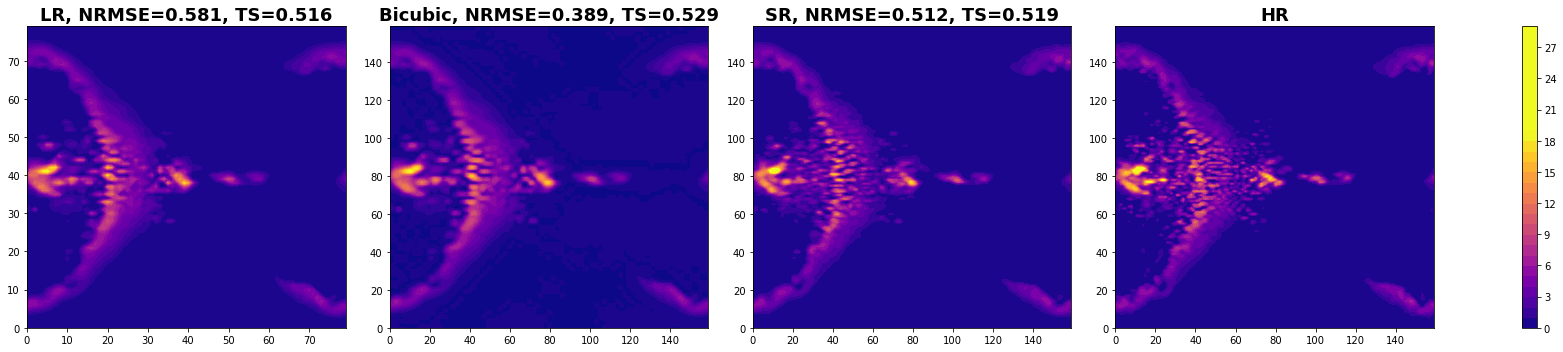

In [13]:
snapshot = 1
input_bicubic_pred_target(Xi_test_LR[snapshot], bic_test[snapshot], pred_test[snapshot], Yi_test[snapshot], test_data = True)

In [21]:
## SR MODEL'S RECONSTRUCTION : SNAPSHOT VISUALIZATION OF SCALE SEPARATION
def input_pred_target(inp, prediction, target, test_data = False):
    nb_levels = 30
    if inp.shape == (80, 80):
        inp_up = np.repeat(np.repeat(inp, 2,  axis=0), 2, axis=1)
    else : 
        inp_up = inp
    if test_data == False :
        cmap = 'viridis'
    else :
        cmap = 'plasma'
        
    std = np.std(target)
    cmin = np.min([np.min(inp), np.min(prediction), np.min(target)])
    cmax = np.max([np.max(inp), np.max(prediction), np.max(target)])
    
    fig1, axs = plt.subplots(figsize = (25,6), nrows=1, ncols=3)
    (ax11, ax12, ax13) = axs
    
    MSE_2D_inp = np.sqrt(np.mean((target - inp_up)**2))/std
    cax11 = ax11.contourf(inp , vmin = cmin, vmax = cmax - 10, cmap = cmap, levels=nb_levels)
    ax11.set_title('LR input : NRMSE=%.3f'%(MSE_2D_inp), fontweight = 'bold', size = 25)

    MSE_2D_pred = np.sqrt(np.mean((target - prediction)**2))/std
    cax12 = ax12.contourf(np.array(prediction), vmin = cmin, vmax = cmax - 10, cmap = cmap, levels=nb_levels)
    ax12.set_title('SR output : NRMSE=%.3f'%MSE_2D_pred, fontweight = 'bold', size = 25)
    
    cax13 = ax13.contourf(target, vmin = cmin, vmax = cmax - 10, cmap = cmap, levels=nb_levels)
    ax13.set_title('HR target', fontweight = 'bold', size = 25)
    
    plt.tight_layout()
    plt.colorbar(cax13, ax=axs)

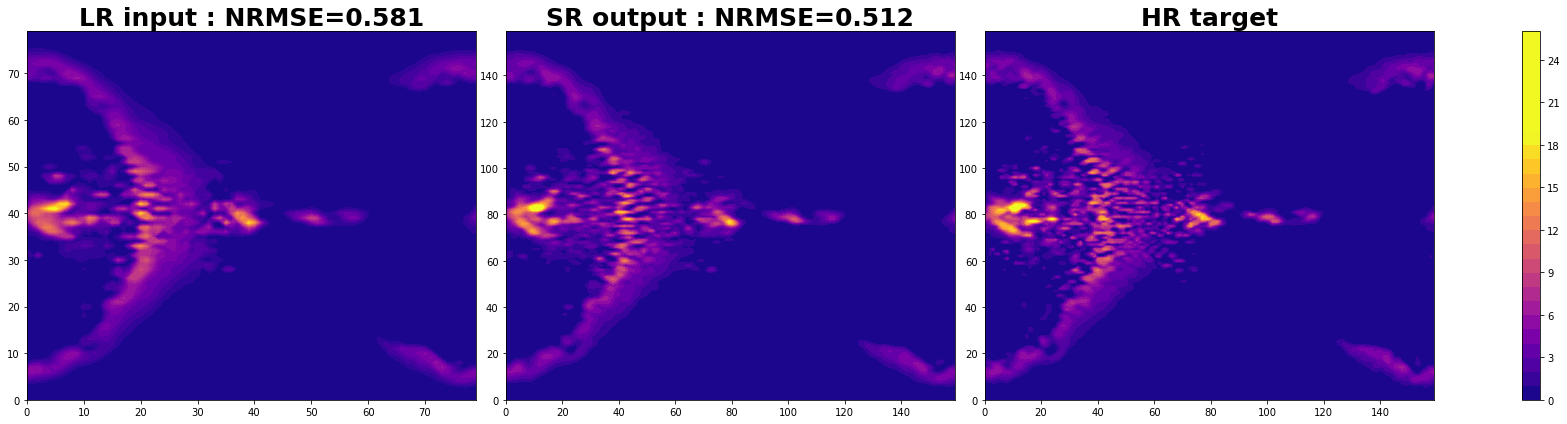

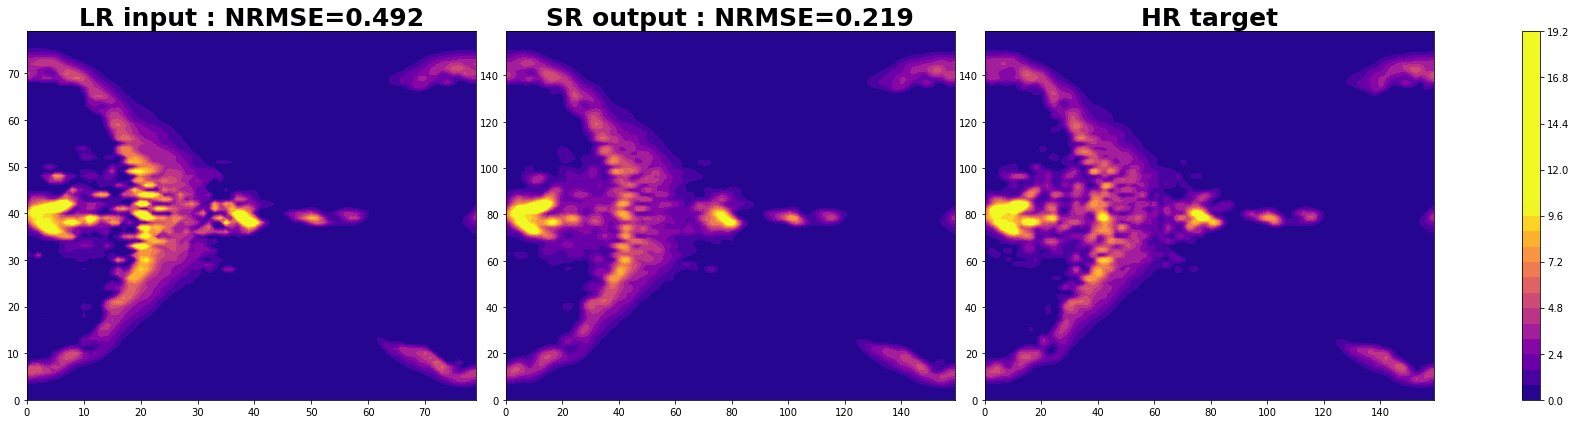

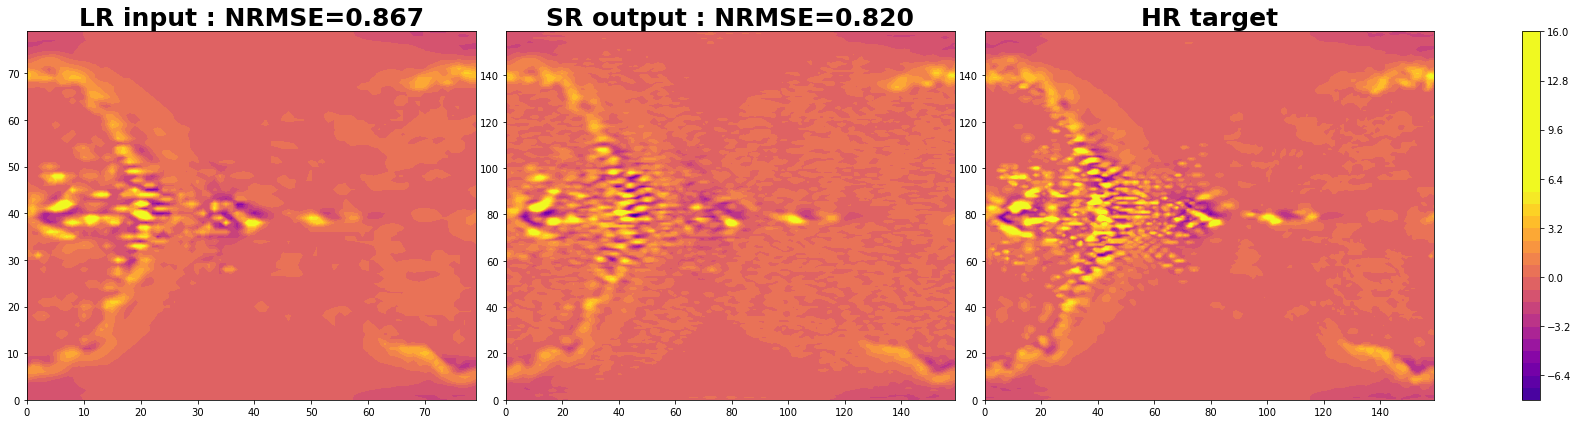

In [22]:
snapshot = 1
input_pred_target(Xi_test_LR[snapshot], pred_test[snapshot], Yi_test[snapshot], test_data = True)
input_pred_target(Xi_test_LR[snapshot], pred_structure_test[snapshot], Yi_test_struc[snapshot], test_data = True)
input_pred_target(Xi_test_LR_res[snapshot], pred_residuals_test[snapshot], Yi_test_res[snapshot], test_data = True)


In [23]:
## CALCULATING MODEL'S OUTPUTS ON TRAIN SET
start = time.time()
pred_structure_train =  np.array(checkpoint.model_struc(Xi_train_LR)).reshape(-1, 160, 160)
pred_residuals_train = np.array(checkpoint.model_res(Xi_train_LR_res)).reshape(-1, 160, 160)
pred_train = np.array(checkpoint.model_rec([pred_structure_train, pred_residuals_train])).reshape(-1, 160, 160)
LR_up_train = np.repeat(np.repeat(Xi_train_LR, 2,  axis=1), 2, axis=2)
bic_train = np.array(tf.image.resize(Xi_train_LR.reshape(800,80,80,1), (160,160), method=tf.image.ResizeMethod.BICUBIC)).reshape(800,160,160)
print('Execution time : %.3fs'%(time.time() - start))
print(pred_train.shape, pred_structure_train.shape, pred_residuals_train.shape, LR_up_train.shape, bic_train.shape)

2022-05-12 13:50:00.430166: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


Execution time : 45.658s
(800, 160, 160) (800, 160, 160) (800, 160, 160) (800, 160, 160) (800, 160, 160)


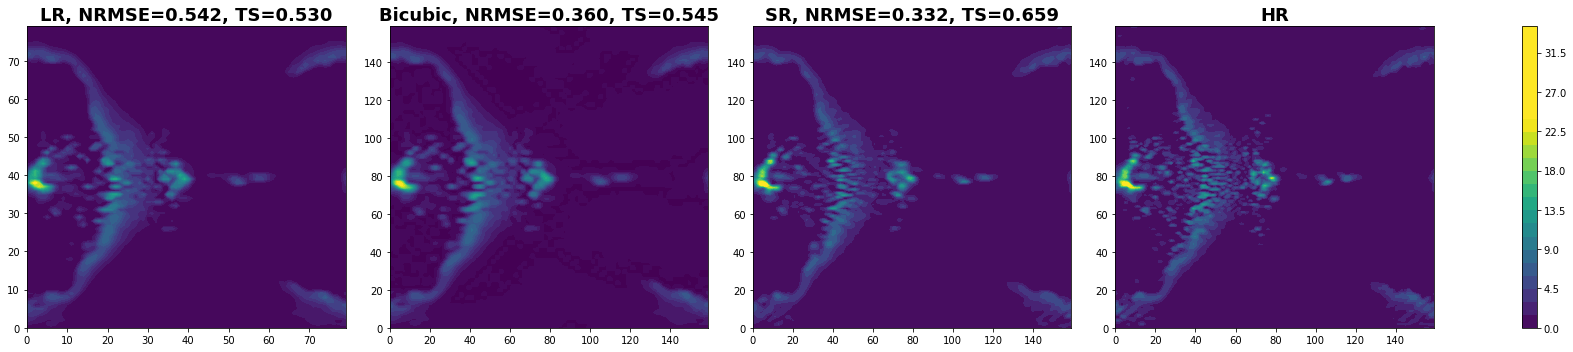

In [24]:
snapshot = 1
input_bicubic_pred_target(Xi_train_LR[snapshot], bic_train[snapshot], pred_train[snapshot], Yi_train[snapshot])

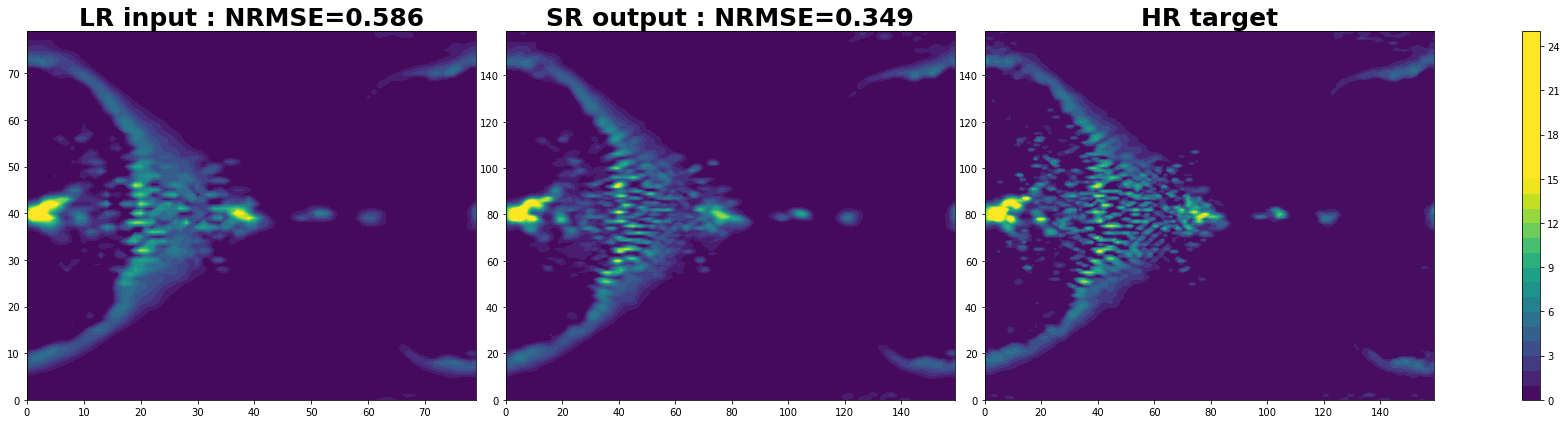

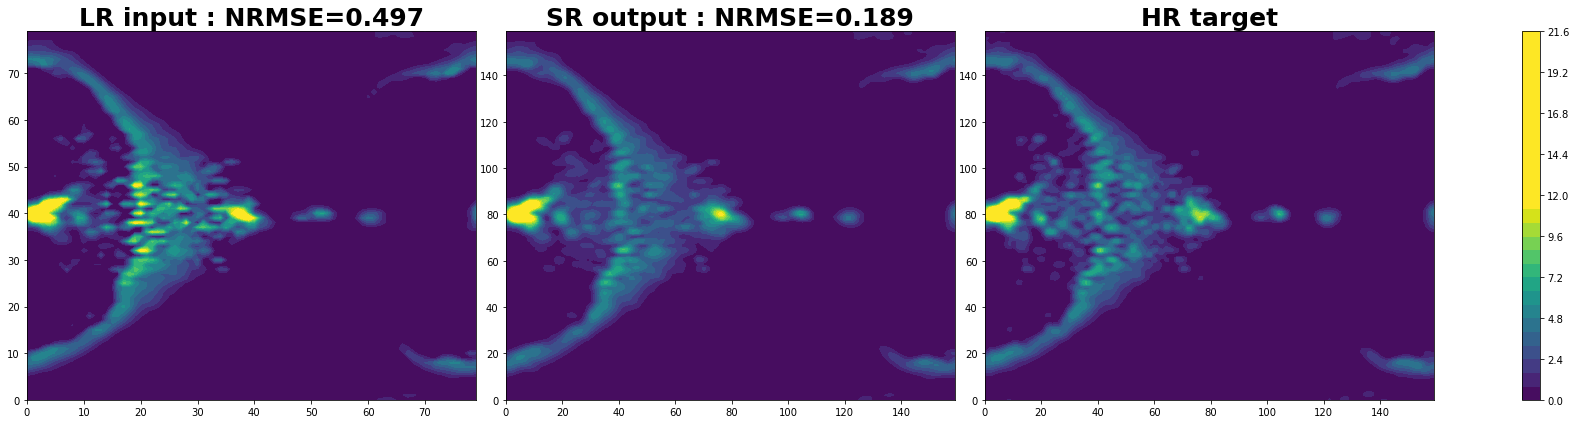

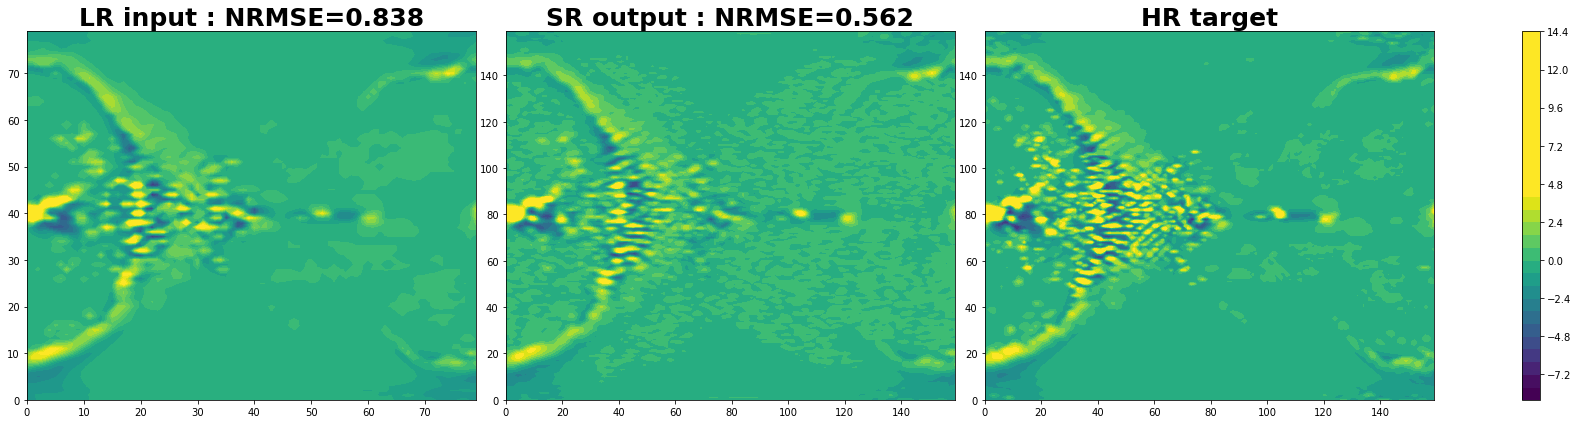

In [25]:
snapshot = 2
input_pred_target(Xi_train_LR[snapshot], pred_train[snapshot], Yi_train[snapshot])
input_pred_target(Xi_train_LR[snapshot], pred_structure_train[snapshot], Yi_train_struc[snapshot])
input_pred_target(Xi_train_LR_res[snapshot], pred_residuals_train[snapshot], Yi_train_res[snapshot])

In [28]:
## ACCURACY PERFORMANCES : NUMERICAL SUMMARY
# Entire reconstruction
LR_test_TS = np.mean(threat_score(Yi_test, LR_up_test)[-1])
bicubic_test_TS = np.mean(threat_score(Yi_test, bic_test)[-1])
test_TS  = np.mean(threat_score(Yi_test, pred_test)[-1])

LR_train_TS = np.mean(threat_score(Yi_train, LR_up_train)[-1])
bicubic_train_TS = np.mean(threat_score(Yi_train, bic_train)[-1])
train_TS = np.mean(threat_score(Yi_train, pred_train)[-1])

LR_test_NRMSE = np.sqrt(np.mean((Yi_test-LR_up_test)**2))/np.std(Yi_test)
bicubic_test_NRMSE = np.sqrt(np.mean((Yi_test-bic_test)**2))/np.std(Yi_test)
SRtest_NRMSE = np.sqrt(np.mean((Yi_test-pred_test)**2))/np.std(Yi_test)

LR_train_NRMSE = np.sqrt(np.mean((Yi_train-LR_up_train)**2))/np.std(Yi_train)
bicubic_train_NRMSE = np.sqrt(np.mean((Yi_train-bic_train)**2))/np.std(Yi_train)
SRtrain_NRMSE = np.sqrt(np.mean((Yi_train-pred_train)**2))/np.std(Yi_train)

print('Reconstruction : Train : TS(LR)    = %.3f   TS(Bic)    = %.3f   TS(SR)    = %.3f'%(LR_train_TS,    bicubic_train_TS,    train_TS))
print('                         NRMSE(LR) = %.3f   NRMSE(Bic) = %.3f   NRMSE(SR) = %.3f'%(LR_train_NRMSE, bicubic_train_NRMSE, SRtrain_NRMSE,))
print('                 Test  : TS(LR)    = %.3f   TS(Bic)    = %.3f   TS(SR)    = %.3f'%(LR_test_TS,     bicubic_test_TS,     test_TS))
print('                         NRMSE(LR) = %.3f   NRMSE(Bic) = %.3f   NRMSE(SR) = %.3f'%(LR_test_NRMSE,  bicubic_test_NRMSE,  SRtest_NRMSE,))

# Structure
train_TS_struc = np.mean(threat_score(Yi_train_struc, pred_structure_train)[-1])
test_TS_struc  = np.mean(threat_score(Yi_test_struc,  pred_structure_test)[-1])
print('Structure      : TS(train) = %.3f    TS(test) = %.3f'%(train_TS_struc, test_TS_struc))

# Residuals
LR_res_test_up  = np.repeat(np.repeat(Xi_test_LR_res,  2,  axis=1), 2, axis=2)
LR_res_train_up = np.repeat(np.repeat(Xi_train_LR_res, 2,  axis=1), 2, axis=2)

train_NRMSE_res = np.sqrt(np.mean((Yi_train_res - pred_residuals_train)**2))/np.std(Yi_train_res)
LR_train_NRMSE_res = np.sqrt(np.mean((Yi_train_res - LR_res_train_up)**2))/np.std(Yi_train_res)

test_NRMSE_res = np.sqrt(np.mean((Yi_test_res - pred_residuals_test)**2))/np.std(Yi_test_res)
LR_test_NRMSE_res = np.sqrt(np.mean((Yi_test_res - LR_res_test_up)**2))/np.std(Yi_test_res)
print('Residuals      : NRMSE(SR train) = %.3f   NRMSE(LR train) = %.3f    NRMSE(SR test) = %.3f   NRMSE(LR test)=%.3f'%(train_NRMSE_res, LR_train_NRMSE_res, test_NRMSE_res, LR_test_NRMSE_res))


Reconstruction : Train : TS(LR)    = 0.476   TS(Bic)    = 0.494   TS(SR)    = 0.608
                         NRMSE(LR) = 0.589   NRMSE(Bic) = 0.548   NRMSE(SR) = 0.368
                 Test  : TS(LR)    = 0.482   TS(Bic)    = 0.501   TS(SR)    = 0.511
                         NRMSE(LR) = 0.578   NRMSE(Bic) = 0.538   NRMSE(SR) = 0.501
Structure      : TS(train) = 0.713    TS(test) = 0.719
Residuals      : NRMSE(SR train) = 0.577   NRMSE(LR train) = 0.854    NRMSE(SR test) = 0.770   NRMSE(LR test)=0.837


In [29]:
## FOURIER TRANSFORM AND SPECTRAL DENSITY ANALYSIS (1D AND 2D PLOTS)
def fourier_transform_1D(array, LR = False):
    """
    :param array: input array (LR or HR)
    :return: a 1D array representing the integrated 2D Fourier Transform of the input array, along r.
    
    if LR == True :
        FFT_2D_small = np.real(np.fft.fftshift(np.fft.fft2(array)))
        FFT_2D = np.zeros((160, 160))
        x_center, y_center = FFT_2D.shape[0]//2,   FFT_2D.shape[1]//2
        x_small , y_small  = FFT_2D_small.shape[0]//2, FFT_2D_small.shape[1]//2
        FFT_2D[x_center-x_small:x_center+x_small, y_center-y_small:y_center+y_small] = FFT_2D_small
    else:
        FFT_2D = np.real(np.fft.fftshift(np.fft.fft2(array)))
    """
    FFT_2D = np.real(np.fft.fftshift(np.fft.fft2(array, norm = 'forward')))
    L = FFT_2D.shape[0] #The length of x and y axes (number of pixels)
    r_max = np.sqrt(2*(L//2)**2)
    x_center, y_center = L//2, L//2
    nbPixels = L**2
    FFT_1D = np.zeros(int(r_max) + 1)
    for x in range(-x_center, x_center, 1):
        for y in range(-y_center, y_center, 1):
            r = int(np.sqrt(x**2  + y**2))
            FFT_1D[r] += np.sum(FFT_2D[x_center + x, y_center + y])
    return FFT_1D

def spectral_density_1D(array, LR = False):
    """
    :param array: input array (LR or HR)
    :return: a 1D array representing the Spectral Density of the input array, along r.
    
    if LR == True:
        SD_2D_small = np.absolute(np.fft.fftshift(np.fft.fft2(array)))**2
        SD_2D = np.zeros((160, 160))
        x_center, y_center = SD_2D.shape[0]//2,   SD_2D.shape[1]//2
        x_small , y_small  = SD_2D_small.shape[0]//2, SD_2D_small.shape[1]//2
        SD_2D[x_center-x_small:x_center+x_small, y_center-y_small:y_center+y_small] = SD_2D_small
    else :
        SD_2D = np.absolute(np.fft.fftshift(np.fft.fft2(array)))**2
    """
    SD_2D = np.absolute(np.fft.fftshift(np.fft.fft2(array, norm = 'forward')))**2
    L = SD_2D.shape[0]  # The length of x and y axes (number of pixels)
    r_max = np.sqrt(2 * (L // 2) ** 2)
    x_center, y_center = L // 2, L // 2
    nbPixels = L ** 2
    SD_1D = np.zeros(int(r_max) + 1)
    for x in range(-x_center, x_center, 1):
        for y in range(-y_center, y_center, 1):
            r = int(np.sqrt(x ** 2 + y ** 2))
            SD_1D[r] += np.sum(SD_2D[x_center + x, y_center + y])
    return SD_1D 

def plot_1D(LR, bic, SR, HR, variable='FT'):
    if variable == 'FT':
        LR_1D = fourier_transform_1D(LR, LR=True)
        bi_1D = fourier_transform_1D(bic)
        SR_1D = fourier_transform_1D(SR)
        HR_1D = fourier_transform_1D(HR)
        print(LR_1D.shape, SR_1D.shape, HR_1D.shape)
        title = 'Integrated Fourier Transform.'
    else :
        LR_1D = spectral_density_1D(LR, LR = True)
        bi_1D = spectral_density_1D(bic)
        SR_1D = spectral_density_1D(SR)
        HR_1D = spectral_density_1D(HR)
        title = 'Real topography : Spectral Density.'

    L = 80 #km
    r_max = np.sqrt(2*L**2)

    nspace_LR = LR_1D.shape[0]
    nspace_HR = HR_1D.shape[0]

    dr_LR = r_max/nspace_HR*2
    dr_HR = r_max/nspace_HR

    r_wvnb_LR = np.round(np.linspace(2 * pi / r_max, 2 * pi / dr_LR, nspace_LR), 2)
    r_wvnb_HR = np.round(np.linspace(2 * pi / r_max, 2 * pi / dr_HR, nspace_HR), 2)

    r_lamb_HR = 2 * pi / r_wvnb_HR
    r_wvnb_ticks = np.flip(np.round(np.linspace(2 * pi / r_max, 2 * pi / dr_HR, 10), 2))
    r_lamb_ticks = np.round(r_lamb_HR[np.mod(np.arange(r_lamb_HR.size), 10) == 0], 2)

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(r_wvnb_LR, LR_1D, label='LR',  color='limegreen')
    ax.plot(r_wvnb_HR, bi_1D, label='bic', color='darkviolet')
    ax.plot(r_wvnb_HR, SR_1D, label='SR',  color='darkorange')
    ax.plot(r_wvnb_HR, HR_1D, label='HR',      color='deepskyblue')
    ax.set_xticks(r_wvnb_ticks)
    ax.set_xlabel('wavenumber k (rad.km-1)', size=15)
    ax.legend(prop={'size': 15})
    ax.set_ylim(1e-18, 10)

    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim()[-1], ax.get_xlim()[0])
    pos1 = ax.get_position()  # get the original position
    pos2 = [pos1.x0, pos1.y0 - 0.3, pos1.width, pos1.height]
    ax2.set_position(pos2)
    ax2.set_xticks(r_wvnb_ticks)
    ax2.set_xlabel('wavelength λ (km)', size=15)
    ax2.set_xticklabels(r_lamb_ticks)
    
    if variable != 'FT':
        ax.set_yscale('log')
    plt.title(title, size=20, fontweight='bold')

def plot_2D(LR, bic, SR, HR, variable='FT'):
    if variable == 'FT':
        bi_2D = np.real(np.fft.fftshift(np.fft.fft2(bic)))
        SR_2D = np.real(np.fft.fftshift(np.fft.fft2(SR)))
        HR_2D = np.real(np.fft.fftshift(np.fft.fft2(HR)))
        LR_2D_small = np.real(np.fft.fftshift(np.fft.fft2(LR)))
        LR_2D_big = np.zeros(bi_2D.shape)
        x_center, y_center = LR_2D_big.shape[0]//2,   LR_2D_big.shape[1]//2
        x_small , y_small  = LR_2D_small.shape[0]//2, LR_2D_small.shape[1]//2
        LR_2D_big[x_center-x_small:x_center+x_small, y_center-y_small:y_center+y_small] = LR_2D_small
        title = '2D Real FT'
    else :
        bi_2D = np.absolute(np.fft.fftshift(np.fft.fft2(bic)))**2
        SR_2D = np.absolute(np.fft.fftshift(np.fft.fft2(SR)))**2
        HR_2D = np.absolute(np.fft.fftshift(np.fft.fft2(HR)))**2
        LR_2D_small = np.absolute(np.fft.fftshift(np.fft.fft2(LR)))**2
        LR_2D_big = np.ones(bi_2D.shape)
        x_center, y_center = LR_2D_big.shape[0]//2,   LR_2D_big.shape[1]//2
        x_small , y_small  = LR_2D_small.shape[0]//2, LR_2D_small.shape[1]//2
        LR_2D_big[x_center-x_small:x_center+x_small, y_center-y_small:y_center+y_small] = LR_2D_small
        title = '2D SD'
    
    sampling_HR = 1  # HR resolution : 1 km
    sampling_LR = 2  # LR resolution : 2 km
    nspace = 160  # domain total length : 160km

    ticks_values = np.arange(0, 161, 20)
    ticks_labels_HR = np.round([i / (nspace * sampling_HR) for i in np.linspace(-nspace, nspace, len(ticks_values))], 2)
    ticks_labels_LR = np.round([i / (nspace * sampling_LR) for i in np.linspace(-nspace, nspace, len(ticks_values))], 2)
    nb_levels = 500

    fig1, axs = plt.subplots(figsize=(20,4), nrows=1, ncols=4)
    (ax11, ax12, ax13, ax14) = axs
    
    if variable == 'FT':
        cax11 = ax11.contourf(LR_2D_big, cmap='plasma', levels = nb_levels, vmin = -2000, vmax = 2000)
    else:
        cax11 = ax11.pcolor(LR_2D_big, cmap='plasma', norm=matplotlib.colors.LogNorm(vmin=1, vmax=LR_2D_big.max()))
    ax11.set_title(title + ' LR.', fontweight='bold', size=20)
    ax11.set_xticklabels(ticks_labels_HR, size=12)
    ax11.set_yticklabels(ticks_labels_HR, size=12)
    ax11.set_xlabel('spatial freq fx (km-1)', size=18)
    ax11.set_ylabel('spatial freq fy (km-1)', size=18)
    
    if variable == 'FT':
        cax12 = ax12.contourf(bi_2D, cmap='plasma', levels = nb_levels, vmin = -2000, vmax = 2000)
    else:
        cax12 = ax12.pcolor(bi_2D, cmap='plasma', norm=matplotlib.colors.LogNorm(vmin=1, vmax=HR_2D.max()))
    ax12.set_title(title + ' bicubic.', fontweight='bold', size=20)
    ax12.set_xticklabels(ticks_labels_HR, size=12)
    ax12.set_yticklabels(ticks_labels_HR, size=12)
    ax12.set_xlabel('spatial freq fx (km-1)', size=18)
    
    if variable == 'FT':
        cax13 = ax13.contourf(SR_2D, cmap='plasma', levels = nb_levels, vmin = -2000, vmax = 2000)
    else:
        cax13 = ax13.pcolor(SR_2D, cmap='plasma', norm=matplotlib.colors.LogNorm(vmin=1, vmax=HR_2D.max()))
    ax13.set_title(title + ' SR.', fontweight='bold', size=20)
    ax13.set_xticklabels(ticks_labels_HR, size=12)
    ax13.set_yticklabels(ticks_labels_HR, size=12)
    ax13.set_xlabel('spatial freq fx (km-1)', size=18)
    
    if variable == 'FT':
        cax14 = ax14.contourf(HR_2D, cmap='plasma', levels = nb_levels, vmin = -2000, vmax = 2000)
    else:
        cax14 = ax14.pcolor(HR_2D, cmap='plasma', norm=matplotlib.colors.LogNorm(vmin=1, vmax=HR_2D.max()))
    ax14.set_title(title + ' HR.', fontweight='bold', size=20)
    ax14.set_xticklabels(ticks_labels_HR, size=12)
    ax14.set_yticklabels(ticks_labels_HR, size=12)
    ax14.set_xlabel('spatial freq fx (km-1)', size=18)
    
    plt.tight_layout()
    plt.colorbar(cax12, ax=axs)

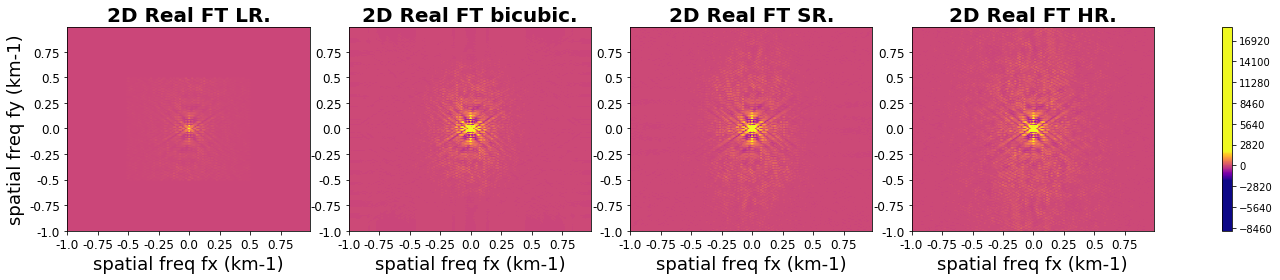

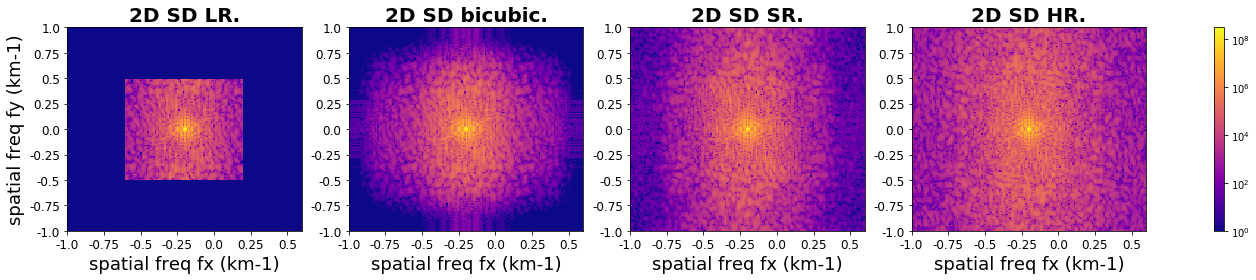

In [30]:
plot_2D(Xi_test_LR[snapshot], bic_test[snapshot], pred_test[snapshot], Yi_test[snapshot], variable = 'FT')
plot_2D(Xi_test_LR[snapshot], bic_test[snapshot], pred_test[snapshot], Yi_test[snapshot], variable = 'SD')

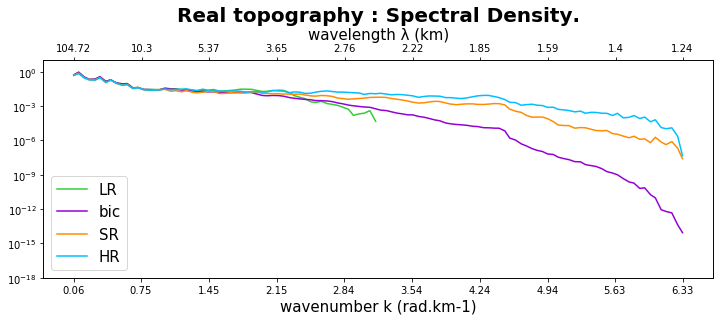

In [32]:
plot_1D(Xi_test_LR[snapshot], bic_test[snapshot], pred_test[snapshot], Yi_test[snapshot], variable = 'SD')

In [33]:
def mutual_information_index(X, Y):
    hist_2d, x_edges, y_edges = np.histogram2d(X,Y,bins=40)
    hist_2d_log = np.zeros(hist_2d.shape)
    non_zeros = hist_2d != 0
    hist_2d_log[non_zeros] = np.log(hist_2d[non_zeros])
    pxy = hist_2d / float(np.sum(hist_2d))
    px = np.sum(pxy, axis=1) 
    py = np.sum(pxy, axis=0)
    px_py = px[:, None] * py[None, :]
    nzs = pxy > 0
    MI = np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))
    return MI, hist_2d_log

def mutual_information_plot(inp, pred, target, dataset = 'train'):
    if dataset == 'train':
        color, cmap = 'rebeccapurple', 'viridis'
    else :
        color, cmap = 'blue','plasma'
        
    X, Y  = pred.ravel(), target.ravel()
    inp_up = np.repeat(np.repeat(inp, 2,  axis=0), 2, axis=1) 
    MI_inp, _ = mutual_information_index(inp_up.ravel(),  target.ravel())
    MI_pred, hist_2d_log = mutual_information_index(pred.ravel(), target.ravel())
    
    fig = plt.figure(figsize = (15,6))
    ax1 = fig.add_subplot(1,2,1)
    plt.axis('equal')
    plt.scatter(X, Y, alpha = 0.2, color = color)
    plt.plot(np.arange(np.min([np.min(X), np.min(Y)]), np.max([np.min(X), np.max(Y)]) + 1, 10),np.arange(np.min([np.min(X), np.min(Y)]), np.max([np.min(X), np.max(Y)]) + 1, 10), color = 'black', linewidth = 2)
    a, b, r, _, _ = stats.linregress(X,Y)
    plt.plot(X, a*X + b, color = 'red', label = 'Regression r = %.3f : y = %.3f x + %.3f'%(r,a,b))
    plt.xlabel('X : Pred values', size = 15)
    plt.ylabel('Y : Target values', size = 15)
    plt.legend(prop = {'size':13})
    plt.title('Scatter plot Pred / Target.', size = 17, fontweight = 'bold')
    ax2 = fig.add_subplot(1,2,2)
    cax2 = plt.imshow(hist_2d_log.T, origin='lower', cmap = cmap)
    plt.xlabel('Px (probability law of X = pred)', size = 15)
    plt.ylabel('Py (probability law of Y = target)', size = 15)
    plt.title('Log 2D Histogram:\n MI_inp=%.3f, MI_pred=%.3f'%(MI_inp, MI_pred), size = 17, fontweight = 'bold')
    plt.colorbar()

In [34]:
## /!\ LONG COMPUTATION
mutual_information_plot(Xi_train_LR_res, pred_residuals_train, Yi_train_res)
mutual_information_plot(Xi_test_LR_res,  pred_residuals_test,  Yi_test_res, dataset = 'test')

/home/gaudrey/.conda/envs/tf-audrey/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


Error in callback <function flush_figures at 0x7f87eb3d8290> (for post_execute):


KeyboardInterrupt: 

In [35]:
def scatter_plot(pred_test, target_test, pred_train, target_train):
    start = time.time()
    Xtest, Ytest, Xtrain, Ytrain  = pred_test.ravel(), target_test.ravel(), pred_train.ravel(), target_train.ravel()
    fig = plt.figure(figsize = (6,6))
    plt.axis('equal')
    plt.scatter(Xtest, Ytest, alpha = 0.2, color = 'lightcoral', label = 'Test')
    plt.scatter(Xtrain, Ytrain, alpha = 0.2, color = 'cornflowerblue', label = 'Train')
    plt.plot(np.arange(-50,50 + 1, 10),np.arange(-50,50 + 1, 10), 'k--', linewidth = 2)
    plt.xlim(-15, 30)
    plt.ylim(-15, 30)
    a, b, r, _, _ = stats.linregress(Xtest,Ytest)
    plt.plot(Xtest, a*Xtest + b, color = 'firebrick', label = 'Fit test : a=%.3f,  r=%.3f'%(a,r))
    a, b, r, _, _ = stats.linregress(Xtrain,Ytrain)
    plt.plot(Xtrain, a*Xtrain + b, color = 'blue', label = 'Fit train : a=%.3f, r=%.3f'%(a,r))
    plt.xlabel('X : Pred values', size = 15)
    plt.ylabel('Y : Target values', size = 15)
    plt.legend(prop = {'size':13}, loc = 'upper left')
    plt.title('SR residuals/HR residuals mapping.', size = 17, fontweight = 'bold')
    print('Computation time: %.3fs'%(time.time()- start))

Computation time: 3.757s


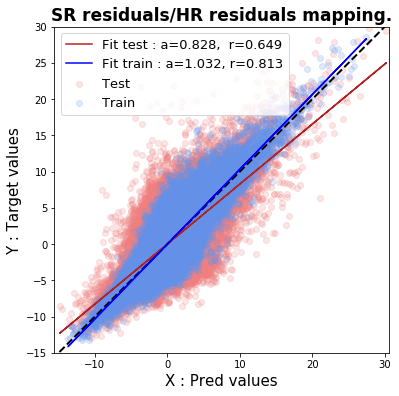

In [36]:
## RESTRAINED NUMBER OF POINTS FOR FASTER COMPUTATION
scatter_plot(pred_residuals_test[:50], Yi_test_res[:50], pred_residuals_train[:50], Yi_train_res[:50])

In [ ]:
## MUTUAL INFORMATION CALCULATION ON ENTIRE RECONSTRUCTION
MI_pred_train, _ = mutual_information_index(pred_train.ravel(), Yi_train.ravel())
MI_inp_train, _ = mutual_information_index(np.repeat(np.repeat(Xi_train_LR, 2,  axis=1), 2, axis=2).ravel(), Yi_train.ravel())
MI_bicubic, _ = mutual_information_index(bicubic.ravel(), Yi_test.ravel())
MI_pred_test, _ = mutual_information_index(pred_test.ravel(), Yi_test.ravel())
MI_inp_test, _ = mutual_information_index(np.repeat(np.repeat(Xi_test_LR, 2,  axis=1), 2, axis=2).ravel(), Yi_test.ravel())
print("Train : MI_pred = %.3f   MI_inp = %.3f"%(MI_pred_train, MI_inp_train))
print("Test  : MI_pred = %.3f   MI_inp = %.3f"%(MI_pred_test,  MI_inp_test))
print(MI_bicubic)

In [ ]:
## MUTUAL INFORMATION CALCULATION ON RESIDUALS
MI_pred_train, _ = mutual_information_index(pred_residuals_train.ravel(), Yi_train_res.ravel())
MI_inp_train, _ = mutual_information_index(np.repeat(np.repeat(Xi_train_LR_res, 2,  axis=1), 2, axis=2).ravel(), Yi_train_res.ravel())
MI_pred_test, _ = mutual_information_index(pred_residuals_test.ravel(), Yi_test_res.ravel())
MI_inp_test, _ = mutual_information_index(np.repeat(np.repeat(Xi_test_LR_res, 2,  axis=0), 2, axis=1).ravel(), Yi_test_res.ravel())
print("Train : MI_pred_res = %.3f   MI_inp_res = %.3f"%(MI_pred_train, MI_inp_train))
print("Test  : MI_pred_res = %.3f   MI_inp_res = %.3f"%(MI_pred_test,  MI_inp_test))

In [ ]:
def fractal_dimension(array, max_box_size = None, min_box_size = 1, n_samples = 20, n_offsets = 0, plot = False):
    """Calculates the fractal dimension of a 3D numpy array.
    
    Args:
        array (np.ndarray): The array to calculate the fractal dimension of.
        max_box_size (int): The largest box size, given as the power of 2 so that
                            2**max_box_size gives the sidelength of the largest box.                     
        min_box_size (int): The smallest box size, given as the power of 2 so that
                            2**min_box_size gives the sidelength of the smallest box.
                            Default value 1.
        n_samples (int): number of scales to measure over.
        n_offsets (int): number of offsets to search over to find the smallest set N(s) to
                       cover  all voxels>0.
        plot (bool): set to true to see the analytical plot of a calculation.
                            
        
    """
    #determine the scales to measure on
    if max_box_size == None:
        #default max size is the largest power of 2 that fits in the smallest dimension of the array:
        max_box_size = int(np.floor(np.log2(np.min(array.shape))))
    scales = np.floor(np.logspace(max_box_size,min_box_size, num = n_samples, base =2 ))
    scales = np.unique(scales) #remove duplicates that could occur as a result of the floor
    
    #get the locations of all non-zero pixels
    locs = np.where(array > 10) # Arbitrary threshold...
    if array.ndim == 2:
        voxels = np.array([(x,y) for x,y in zip(*locs)])
    else :
        voxels = np.array([(x,y,z) for x,y,z in zip(*locs)])
    
    #count the minimum amount of boxes touched
    Ns = []
    #loop over all scales
    for scale in scales:
        touched = []
        if n_offsets == 0:
            offsets = [0]
        else:
            offsets = np.linspace(0, scale, n_offsets)
        #search over all offsets
        for offset in offsets:
            bin_edges = [np.arange(0, i, scale) for i in array.shape]
            bin_edges = [np.hstack([0-offset,x + offset]) for x in bin_edges]
            H1, e = np.histogramdd(voxels, bins = bin_edges)
            touched.append(np.sum(H1>0))
        Ns.append(touched)
    Ns = np.array(Ns)
    
    #From all sets N found, keep the smallest one at each scale
    Ns = Ns.min(axis=1)
    
    #Only keep scales at which Ns changed
    scales  = np.array([np.min(scales[Ns == x]) for x in np.unique(Ns)])
    
    Ns = np.unique(Ns)
    Ns = Ns[Ns > 0]
    scales = scales[:len(Ns)]
    #perform fit
    coeffs = np.polyfit(np.log(1/scales), np.log(Ns),1)
    
    #make plot
    if plot:
        fig, ax = plt.subplots(figsize = (8,6))
        ax.scatter(np.log(1/scales), np.log(np.unique(Ns)), c = "teal", label = "Measured ratios")
        ax.set_ylabel("$\log N(\epsilon)$")
        ax.set_xlabel("$\log 1/ \epsilon$")
        fitted_y_vals = np.polyval(coeffs, np.log(1/scales))
        ax.plot(np.log(1/scales), fitted_y_vals, "k--", label = f"Fit: {np.round(coeffs[0],3)}X+{coeffs[1]}")
        ax.legend();
    return coeffs, scales, Ns

def fractal_dimension_plot(inp, bicubic, pred, target, max_box_size = None, min_box_size = 1, n_samples = 20, n_offsets = 0):
    fig = plt.figure(figsize=(20,4))
    inp_up = np.repeat(np.repeat(inp, 2,  axis=0), 2, axis=1) 
    coeffs_inp, scales_inp, Ns_inp = fractal_dimension(inp_up)
    ax1 = fig.add_subplot(1,4,1)
    ax1.scatter(np.log(1/scales_inp), np.log(np.unique(Ns_inp)), c = 'limegreen', label = "Measured ratios")
    ax1.set_ylabel("$\log N(\epsilon)$", size = 15)
    ax1.set_xlabel("$\log 1/ \epsilon$", size = 15)
    fitted_y_vals = np.polyval(coeffs_inp, np.log(1/scales_inp))
    ax1.plot(np.log(1/scales_inp), fitted_y_vals, "k--", label = f"Fit: {np.round(coeffs_inp[0],3)}X+{np.round(coeffs_inp[1],3)}")
    ax1.legend(prop = {'size':13}, loc = 'upper left');
    plt.title('LR : FD=%.3f'%coeffs_inp[0], size = 18, fontweight = 'bold')
    
    coeffs_bic, scales_bic, Ns_bic = fractal_dimension(bicubic)
    ax2 = fig.add_subplot(1,4,2)
    ax2.scatter(np.log(1/scales_bic), np.log(np.unique(Ns_bic)), c = 'darkviolet', label = "Measured ratios")
    ax2.set_ylabel("$\log N(\epsilon)$", size = 17)
    ax2.set_xlabel("$\log 1/ \epsilon$", size = 17)
    fitted_y_vals = np.polyval(coeffs_bic, np.log(1/scales_bic))
    ax2.plot(np.log(1/scales_bic), fitted_y_vals, "k--", label = f"Fit: {np.round(coeffs_bic[0],3)}X+{np.round(coeffs_bic[1],3)}")
    ax2.legend(prop = {'size':13}, loc = 'upper left');
    plt.title('Bic : FD=%.3f'%coeffs_bic[0], size = 18, fontweight = 'bold')
    
    coeffs_pred, scales_pred, Ns_pred = fractal_dimension(pred)
    ax3 = fig.add_subplot(1,4,3)
    ax3.scatter(np.log(1/scales_pred), np.log(np.unique(Ns_pred)), c = 'orange', label = "Measured ratios")
    ax3.set_ylabel("$\log N(\epsilon)$", size = 17)
    ax3.set_xlabel("$\log 1/ \epsilon$", size = 17)
    fitted_y_vals = np.polyval(coeffs_pred, np.log(1/scales_pred))
    ax3.plot(np.log(1/scales_pred), fitted_y_vals, "k--", label = f"Fit: {np.round(coeffs_pred[0],3)}X+{np.round(coeffs_pred[1],3)}")
    ax3.legend(prop = {'size':13}, loc = 'upper left');
    plt.title('SR : FD=%.3f'%coeffs_pred[0], size = 18, fontweight = 'bold')
    
    coeffs_target, scales_target, Ns_target = fractal_dimension(target)
    ax4 = fig.add_subplot(1,4,4)
    ax4.scatter(np.log(1/scales_target), np.log(np.unique(Ns_target)), c = 'deepskyblue', label = "Measured ratios")
    ax4.set_ylabel("$\log N(\epsilon)$", size = 17)
    ax4.set_xlabel("$\log 1/ \epsilon$", size = 17)
    fitted_y_vals = np.polyval(coeffs_target, np.log(1/scales_target))
    ax4.plot(np.log(1/scales_target), fitted_y_vals, "k--", label = f"Fit: {np.round(coeffs_target[0],3)}X+{np.round(coeffs_target[1],3)}")
    ax4.legend(prop = {'size':13}, loc = 'upper left');
    plt.title('HR : FD=%.3f'%coeffs_target[0], size = 18, fontweight = 'bold')

In [ ]:
fractal_dimension_plot(LR_up_test, bic_test,  pred_test, Yi_test, n_samples = 20)